In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score, confusion_matrix

In [2]:
colors = sns.color_palette("hls", 8)
colors

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.7612000000000001, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.5012000000000001),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.43879999999999986, 0.86),
 (0.6311999999999998, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.6987999999999996)]

# Rename image

In [16]:
data = []
counter = 0
for name_pref in ['accordeon', 'dombyra', 'kobyz']:
    i = 0
    for root, dirs, files in os.walk("/kaggle/input/kaz-instruments/data/" + name_pref, topdown=False):
        for name in files:
            try:
                os.rename(f'{root}\\{name}', f'{root}\\{name_pref}{i:04d}.jpg')
                img = cv2.imread(f'{root}/{name}')
                data.append((counter, name_pref, name, img.shape[0], img.shape[1], img.ravel().mean(), img[:,:,0].mean(), img[:,:,1].mean(), img[:,:,2].mean()))
                i+=1
                counter+=1
            except AttributeError:
                print(i, root, name)

43 /kaggle/input/kaz-instruments/data/accordeon accordeon0222.jpg
232 /kaggle/input/kaz-instruments/data/accordeon accordeon0223.jpg


# Exploratory data analysis

In [17]:
image_data = pd.DataFrame(data=data, columns=['id', 'y', 'label', 'width', 'height', 
                                 'total_intense', 'red_intense', 'green_intense', 'blue_intense']).set_index('id')

In [18]:
image_data.head()

,y,label,width,height,total_intense,red_intense,green_intense,blue_intense
id,,,,,,,,
0,accordeon,accordeon0052.jpg,1050,1403,103.598638,98.296728,103.114164,109.385023
1,accordeon,accordeon0245.jpg,183,275,83.605796,89.263766,84.451684,77.101937
2,accordeon,accordeon0132.jpg,225,225,201.405537,199.355516,200.488198,204.372899
3,accordeon,accordeon0021.jpg,183,275,50.514211,21.933095,37.444789,92.164749
4,accordeon,accordeon0196.jpg,960,1280,122.278923,119.429621,116.308235,131.098913


In [19]:
image_data.describe()

,width,height,total_intense,red_intense,green_intense,blue_intense
count,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000
mean,380.194805,405.400974,152.245348,145.645328,150.957762,160.132953
std,474.517241,458.221773,50.872773,52.669776,51.715261,51.579499
min,100.000000,100.000000,12.937457,9.012630,13.370006,16.429733
25%,186.750000,194.000000,115.301189,105.949958,113.213844,121.574681
50%,225.000000,259.000000,148.609597,141.288668,146.821682,158.885257
75%,357.750000,351.500000,193.140418,187.610827,190.626775,204.537965
max,4608.000000,4472.000000,250.977433,249.300396,251.396207,252.235697


In [20]:
image_data.shape

(616, 8)

#### Image width and height distributions

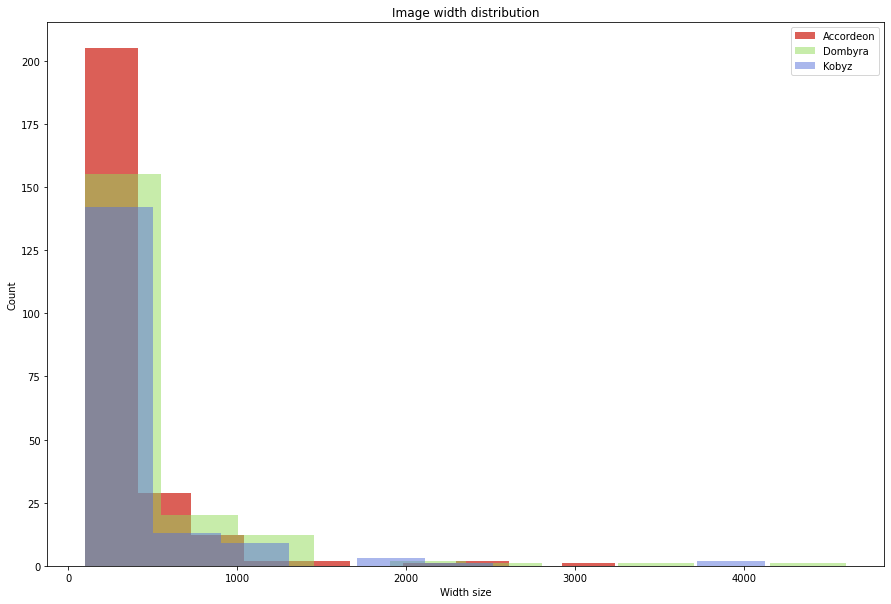

In [21]:
plt.figure(figsize=(15,10))
plt.hist(image_data[image_data['y']=='accordeon']['width'],  color = colors[0], )
plt.hist(image_data[image_data['y']=='dombyra']['width'],  color = colors[2], alpha = 0.5)
plt.hist(image_data[image_data['y']=='kobyz']['width'],  color = colors[5], alpha = 0.5)
plt.title(f'Image width distribution')
plt.xlabel('Width size')
plt.ylabel('Count')
plt.legend(['Accordeon', 'Dombyra', 'Kobyz'])
plt.show()

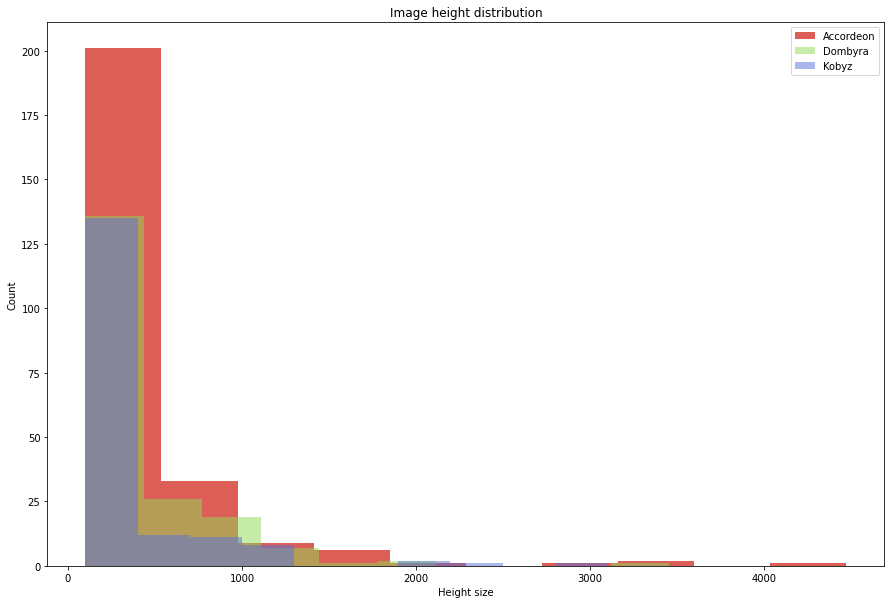

In [22]:
plt.figure(figsize=(15,10))
plt.hist(image_data[image_data['y']=='accordeon']['height'],  color = colors[0], )
plt.hist(image_data[image_data['y']=='dombyra']['height'],  color = colors[2], alpha = 0.5)
plt.hist(image_data[image_data['y']=='kobyz']['height'],  color = colors[5], alpha = 0.5)
plt.title(f'Image height distribution')
plt.xlabel('Height size')
plt.ylabel('Count')
plt.legend(['Accordeon', 'Dombyra', 'Kobyz'])
plt.show()

> On these charts, we can see the exponential distribution. <br>
The distribution is roughly the same in all classes.

#### Colors and intense distributions

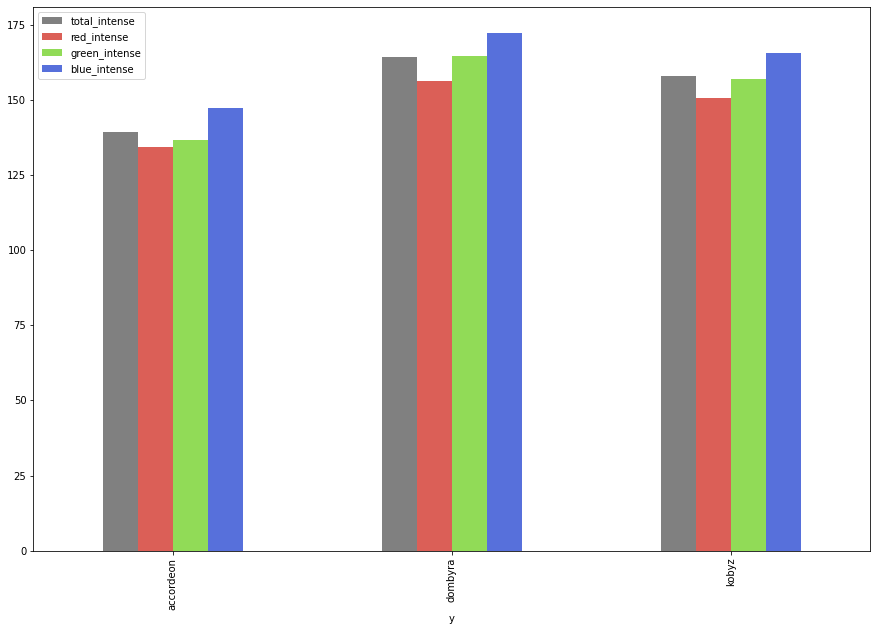

In [23]:
image_data.groupby('y')[['total_intense', 'red_intense', 
                         'green_intense', 'blue_intense']].mean().plot(figsize=(15, 10), 
                        kind='bar', legend=['Total intense', 'Red intense', 'Green intense', 'Blue intense'],
                        color = ['gray', colors[0], colors[2], colors[5]]);

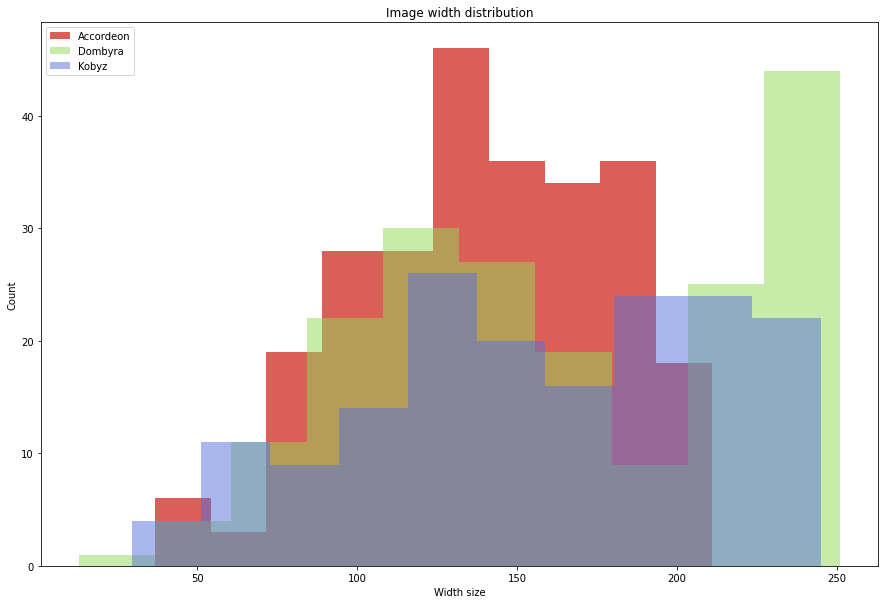

In [24]:
plt.figure(figsize=(15,10))
plt.hist(image_data[image_data['y']=='accordeon']['total_intense'], color = colors[0])
plt.hist(image_data[image_data['y']=='dombyra']['total_intense'], color = colors[2], alpha = 0.5)
plt.hist(image_data[image_data['y']=='kobyz']['total_intense'], color = colors[5], alpha = 0.5)
plt.title(f'Image width distribution')
plt.xlabel('Width size')
plt.ylabel('Count')
plt.legend(['Accordeon', 'Dombyra', 'Kobyz'])
plt.show()

In [25]:
def draw_color_hist(y):
    plt.figure(figsize=(15,10))
    if y != 'all':
        plt.hist(image_data[image_data['y']==y]['total_intense'], bins = 256, color = 'grey', alpha=0.5)
        plt.hist(image_data[image_data['y']==y]['red_intense'], bins = 256, color = colors[0], alpha = 0.5)
        plt.hist(image_data[image_data['y']==y]['green_intense'], bins = 256, color = colors[2], alpha = 0.5)
        plt.hist(image_data[image_data['y']==y]['blue_intense'], bins = 256, color = colors[5], alpha = 0.5)
    else:
        plt.hist(image_data['total_intense'], bins = 256, color = 'grey', )
        plt.hist(image_data['red_intense'], bins = 256, color = colors[0], alpha = 0.5)
        plt.hist(image_data['green_intense'], bins = 256, color = colors[2], alpha = 0.5)
        plt.hist(image_data['blue_intense'], bins = 256, color = colors[5], alpha = 0.5)
    plt.title(f'Color histogram {y}')
    plt.xlabel('Intensity Value')
    plt.ylabel('Count')
    plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
    plt.show()

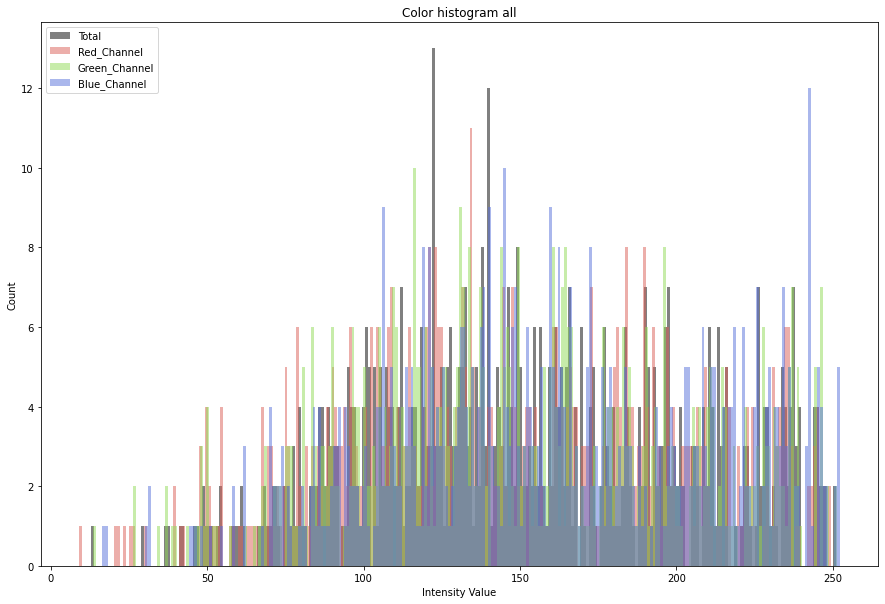

In [26]:
draw_color_hist('all')

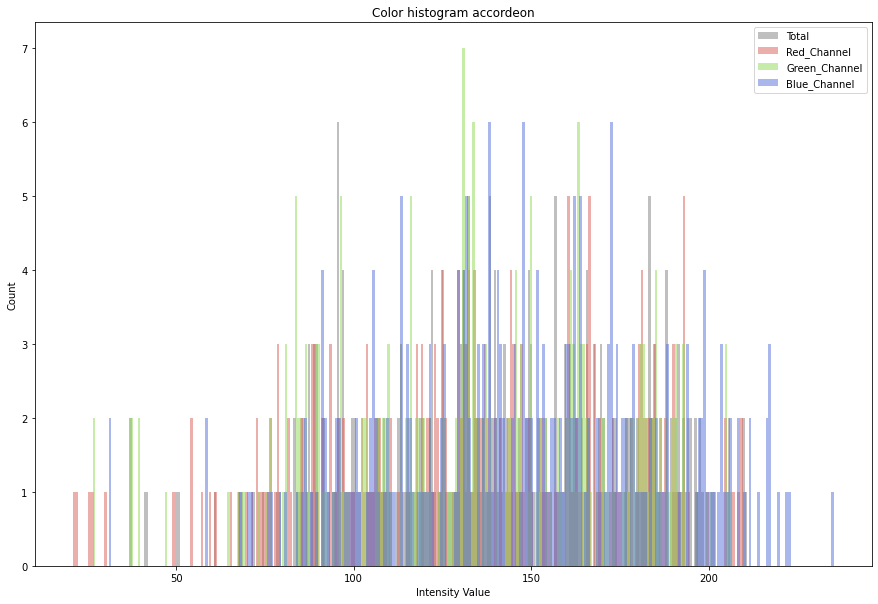

In [27]:
draw_color_hist('accordeon')

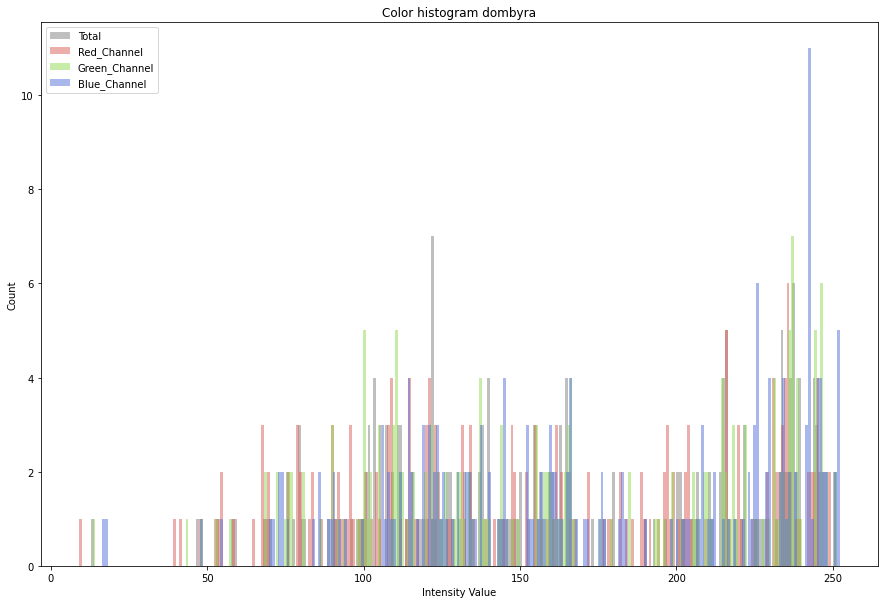

In [28]:
draw_color_hist('dombyra')

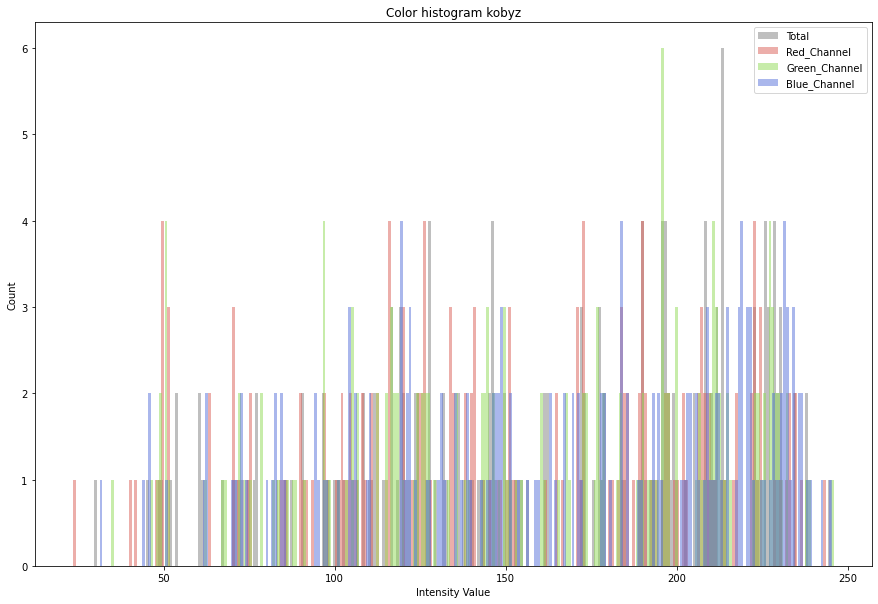

In [29]:
draw_color_hist('kobyz')

> In the case of colors, the intensity distributions differ but are roughly equal in general terms. <br>
> The intensity distribution resembles a normal distribution and only dombra showed a binormal distribution.
> 
> The first diagram shows that the color distributions differ only in absolute value. <br>
> Pictures with dombra are on average brighter than other classes.

# Model preporation

## Train, test splitting

In [30]:
batch_size = 32
image_size = 224

### 80/20

In [32]:
datagen_80_20 = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, validation_split=0.2)


df_train_80_20 = datagen_80_20.flow_from_directory(
        "/kaggle/input/kaz-instruments/data/",
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical', subset='training')


df_test_80_20 = datagen_80_20.flow_from_directory(
        "/kaggle/input/kaz-instruments/data/",
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical', subset='validation')

Found 495 images belonging to 3 classes.
Found 123 images belonging to 3 classes.


### 70/30

In [33]:
datagen_70_30 = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, validation_split=0.3)


df_train_70_30 = datagen_70_30.flow_from_directory(
        "/kaggle/input/kaz-instruments/data/",
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical', subset='training')


df_test_70_30 = datagen_70_30.flow_from_directory(
        "/kaggle/input/kaz-instruments/data/",
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical', subset='validation')

Found 434 images belonging to 3 classes.
Found 184 images belonging to 3 classes.


# Custom CNN model

In [38]:
def customModel():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(3, activation="softmax")])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[tf.metrics.categorical_accuracy, tf.metrics.AUC(), tf.metrics.binary_accuracy])
    
    return model

## Train model on 80/20 dataset

In [39]:
custom_model_80_20 = customModel()
with tf.device("GPU"):
    history_80_20 = custom_model_80_20.fit(df_train_80_20, validation_data=df_test_80_20, epochs=50)

Epoch 1/50
16/16 [==============================] - 12s 666ms/step - loss: 1.9849 - categorical_accuracy: 0.4047 - auc: 0.5558 - binary_accuracy: 0.6649 - val_loss: 0.7596 - val_categorical_accuracy: 0.6585 - val_auc: 0.8336 - val_binary_accuracy: 0.7832
Epoch 2/50
16/16 [==============================] - 9s 564ms/step - loss: 0.7408 - categorical_accuracy: 0.6692 - auc: 0.8499 - binary_accuracy: 0.7912 - val_loss: 0.5097 - val_categorical_accuracy: 0.7724 - val_auc: 0.9324 - val_binary_accuracy: 0.8482
Epoch 3/50
16/16 [==============================] - 10s 597ms/step - loss: 0.5253 - categorical_accuracy: 0.7871 - auc: 0.9261 - binary_accuracy: 0.8547 - val_loss: 0.4480 - val_categorical_accuracy: 0.7724 - val_auc: 0.9410 - val_binary_accuracy: 0.8509
Epoch 4/50
16/16 [==============================] - 10s 631ms/step - loss: 0.5226 - categorical_accuracy: 0.7644 - auc: 0.9283 - binary_accuracy: 0.8568 - val_loss: 0.4765 - val_categorical_accuracy: 0.7724 - val_auc: 0.9399 - val_binar

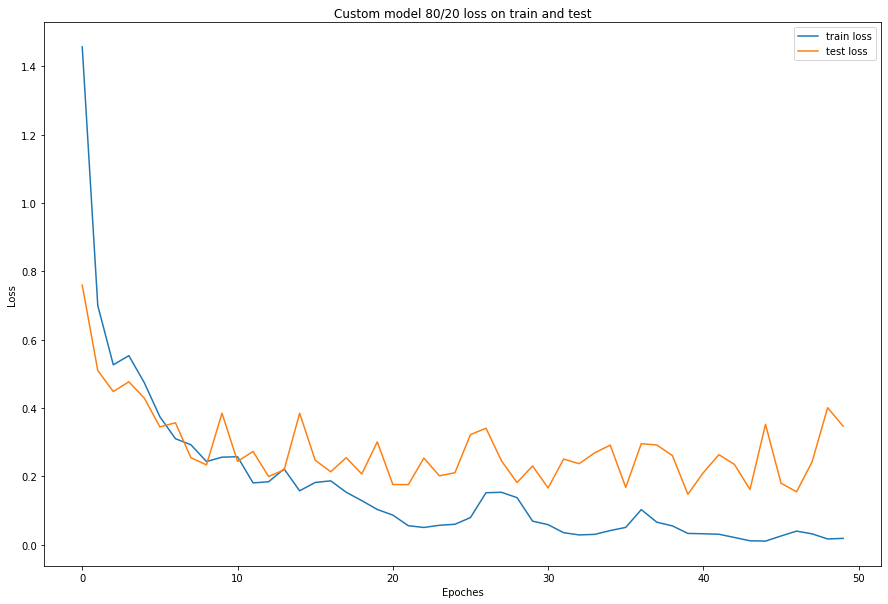

In [40]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(50), history_80_20.history['loss'], label='train loss')
plt.plot(np.arange(50), history_80_20.history['val_loss'], label='test loss')

plt.legend()
plt.title(f'Custom model 80/20 loss on train and test')
plt.xlabel('Epoches')
plt.ylabel('Loss');

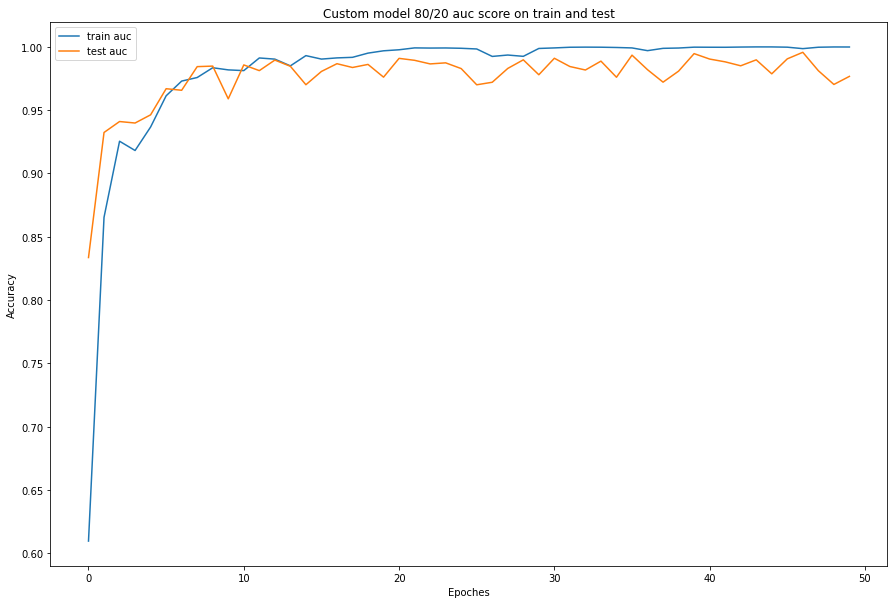

In [43]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(50), history_80_20.history['auc'], label='train auc')
plt.plot(np.arange(50), history_80_20.history['val_auc'], label='test auc')

plt.legend()
plt.title(f'Custom model 80/20 auc score on train and test')
plt.xlabel('Epoches')
plt.ylabel('Accuracy');

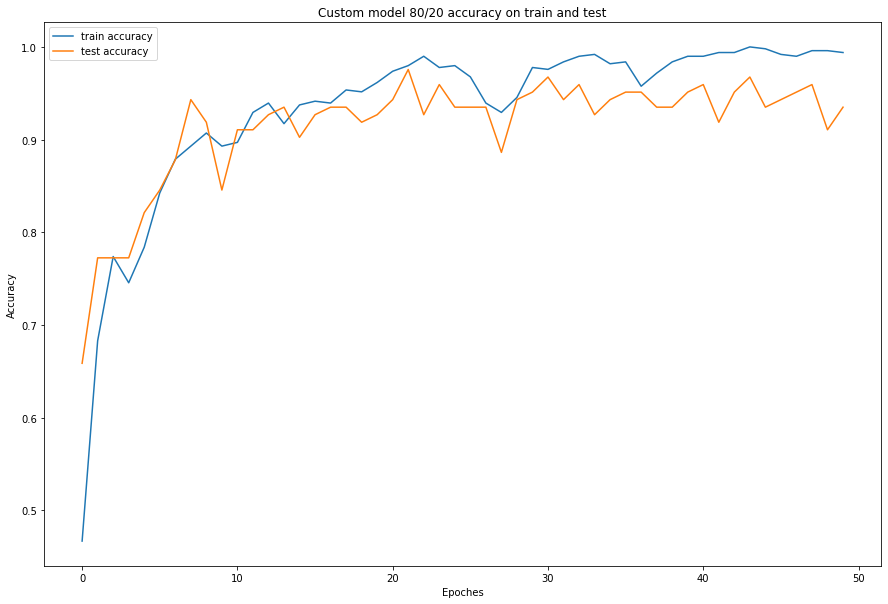

In [44]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(50), history_80_20.history['categorical_accuracy'], label='train accuracy')
plt.plot(np.arange(50), history_80_20.history['val_categorical_accuracy'], label='test accuracy')

plt.legend()
plt.title(f'Custom model 80/20 accuracy on train and test')
plt.xlabel('Epoches')
plt.ylabel('Accuracy');

> When training a custom model, you can see a standard situation when losses decrease and accuracy increases.

## Train model on 70/30 dataset

In [45]:
custom_model_70_30 = customModel()
with tf.device("GPU"):
    history_70_30 = custom_model_70_30.fit(df_train_70_30, validation_data=df_test_70_30, epochs=50)

Epoch 1/50
14/14 [==============================] - 11s 761ms/step - loss: 3.2690 - categorical_accuracy: 0.3826 - auc_2: 0.5459 - binary_accuracy: 0.6411 - val_loss: 0.6761 - val_categorical_accuracy: 0.7011 - val_auc_2: 0.8743 - val_binary_accuracy: 0.7862
Epoch 2/50
14/14 [==============================] - 10s 702ms/step - loss: 0.7175 - categorical_accuracy: 0.6268 - auc_2: 0.8524 - binary_accuracy: 0.7713 - val_loss: 0.6800 - val_categorical_accuracy: 0.6739 - val_auc_2: 0.8686 - val_binary_accuracy: 0.7880
Epoch 3/50
14/14 [==============================] - 10s 734ms/step - loss: 0.6271 - categorical_accuracy: 0.6920 - auc_2: 0.8885 - binary_accuracy: 0.8036 - val_loss: 0.5083 - val_categorical_accuracy: 0.7717 - val_auc_2: 0.9269 - val_binary_accuracy: 0.8442
Epoch 4/50
14/14 [==============================] - 10s 724ms/step - loss: 0.4829 - categorical_accuracy: 0.7925 - auc_2: 0.9338 - binary_accuracy: 0.8626 - val_loss: 0.4209 - val_categorical_accuracy: 0.8207 - val_auc_2: 0

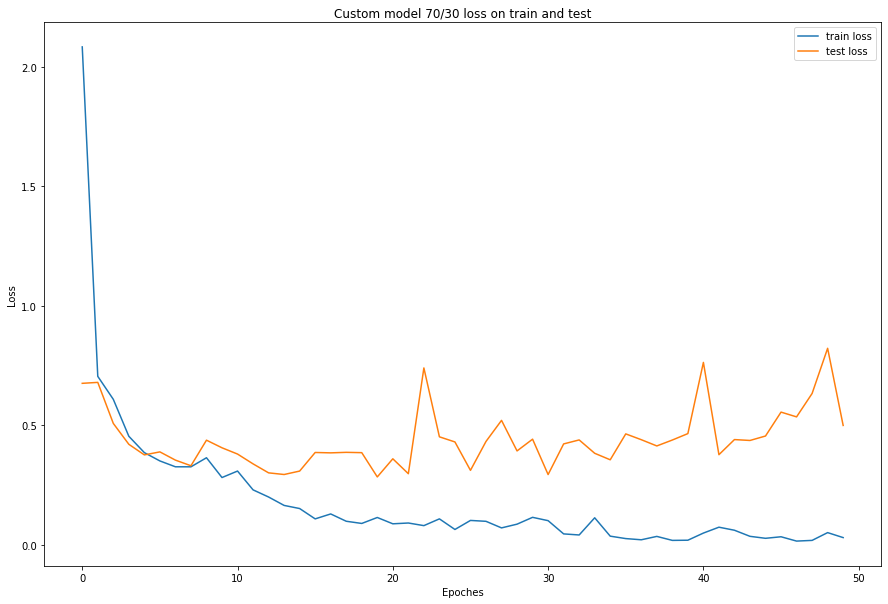

In [48]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(50), history_70_30.history['loss'], label='train loss')
plt.plot(np.arange(50), history_70_30.history['val_loss'], label='test loss')

plt.legend()
plt.title(f'Custom model 70/30 loss on train and test')
plt.xlabel('Epoches')
plt.ylabel('Loss');

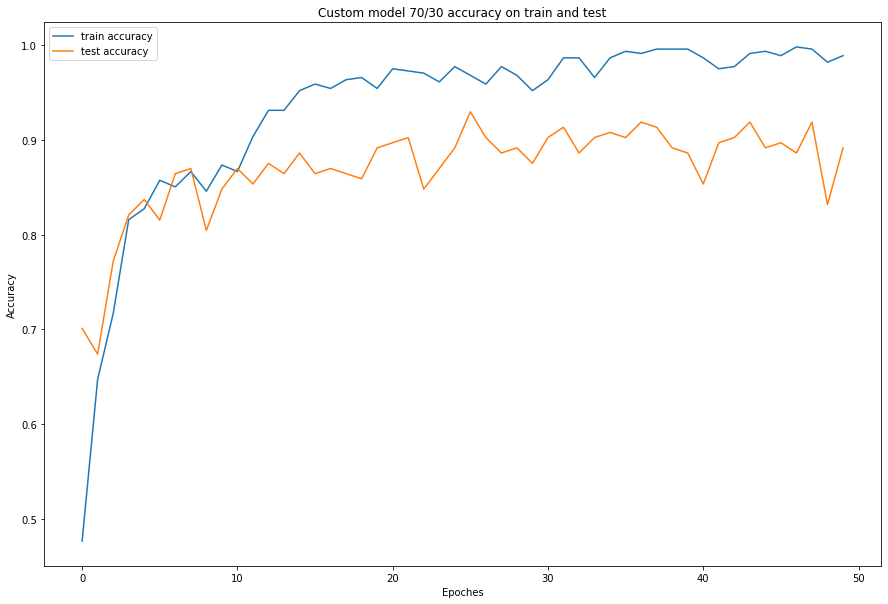

In [49]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(50), history_70_30.history['categorical_accuracy'], label='train accuracy')
plt.plot(np.arange(50), history_70_30.history['val_categorical_accuracy'], label='test accuracy')

plt.legend()
plt.title(f'Custom model 70/30 accuracy on train and test')
plt.xlabel('Epoches')
plt.ylabel('Accuracy');

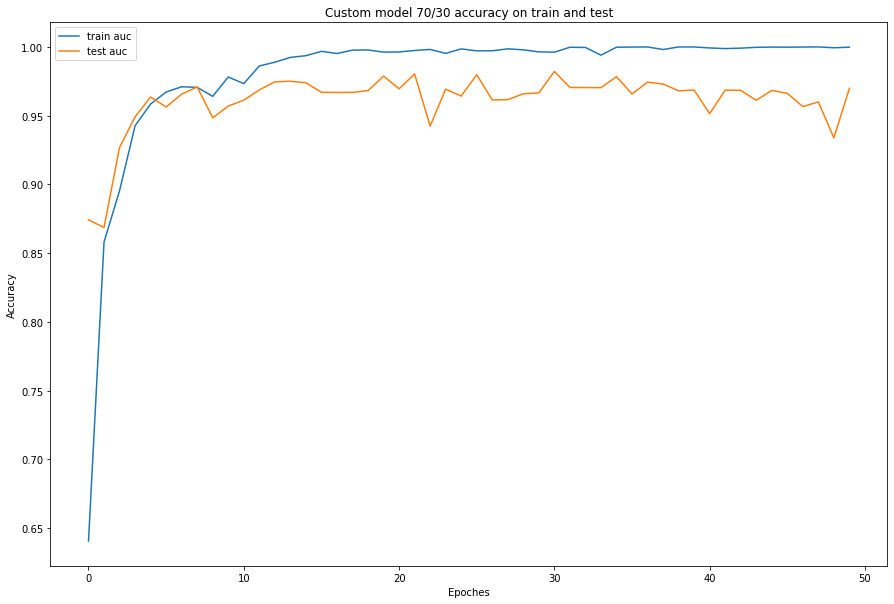

In [51]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(50), history_70_30.history['auc_2'], label='train auc')
plt.plot(np.arange(50), history_70_30.history['val_auc_2'], label='test auc')

plt.legend()
plt.title(f'Custom model 70/30 accuracy on train and test')
plt.xlabel('Epoches')
plt.ylabel('Accuracy');

> In the case of dividing the data in proportions 70/30, the result is hardly distinguishable from 80/20

# Pre-trained model MobileNet

In [52]:
def mobileNetV2Model():
    model = tf.keras.models.Sequential([
        tf.keras.applications.MobileNetV2(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(3, activation="softmax")])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[tf.metrics.categorical_accuracy, tf.metrics.AUC(), tf.metrics.binary_accuracy])
    
    return model

## Train model on 80/20 dataset

In [53]:
mob_net_model_80_20 = mobileNetV2Model()
with tf.device("GPU"):
    history_80_20 = mob_net_model_80_20.fit(df_train_80_20, validation_data=df_test_80_20, epochs=50)

14540800/14536120 [==============================] - 0s 0us/step
Epoch 1/50
16/16 [==============================] - 16s 759ms/step - loss: 1.0558 - categorical_accuracy: 0.6511 - auc_3: 0.7547 - binary_accuracy: 0.6667 - val_loss: 0.9882 - val_categorical_accuracy: 0.7724 - val_auc_3: 0.8660 - val_binary_accuracy: 0.6667
Epoch 2/50
16/16 [==============================] - 9s 598ms/step - loss: 0.9242 - categorical_accuracy: 0.9324 - auc_3: 0.9698 - binary_accuracy: 0.6667 - val_loss: 1.0310 - val_categorical_accuracy: 0.5285 - val_auc_3: 0.7134 - val_binary_accuracy: 0.6667
Epoch 3/50
16/16 [==============================] - 10s 595ms/step - loss: 0.8509 - categorical_accuracy: 0.8623 - auc_3: 0.9271 - binary_accuracy: 0.7517 - val_loss: 0.9036 - val_categorical_accuracy: 0.6911 - val_auc_3: 0.7402 - val_binary_accuracy: 0.7724
Epoch 4/50
16/16 [==============================] - 10s 601ms/step - loss: 0.7333 - categorical_accuracy: 0.8834 - auc_3: 0.9506 - binary_accuracy: 0.8260 - va

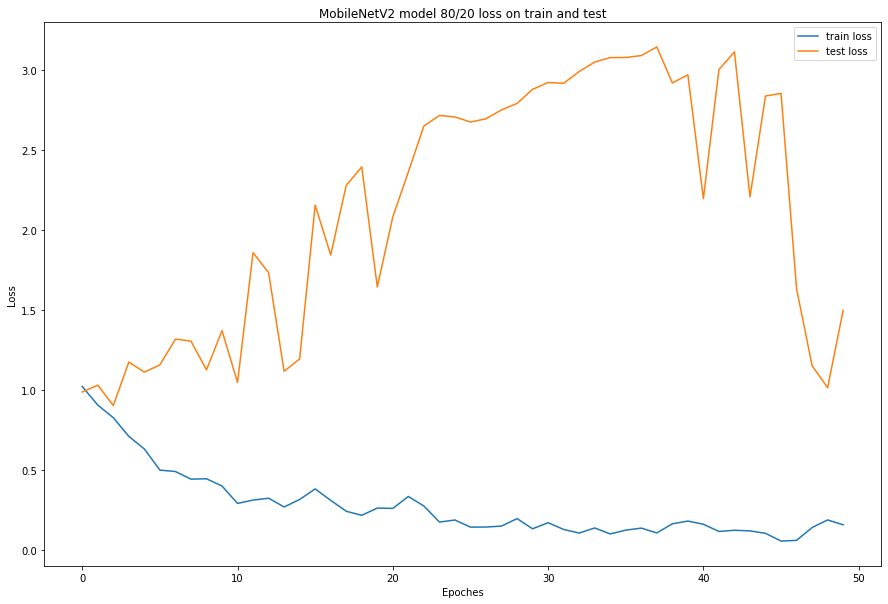

In [54]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(50), history_80_20.history['loss'], label='train loss')
plt.plot(np.arange(50), history_80_20.history['val_loss'], label='test loss')

plt.legend()
plt.title(f'MobileNetV2 model 80/20 loss on train and test')
plt.xlabel('Epoches')
plt.ylabel('Loss');

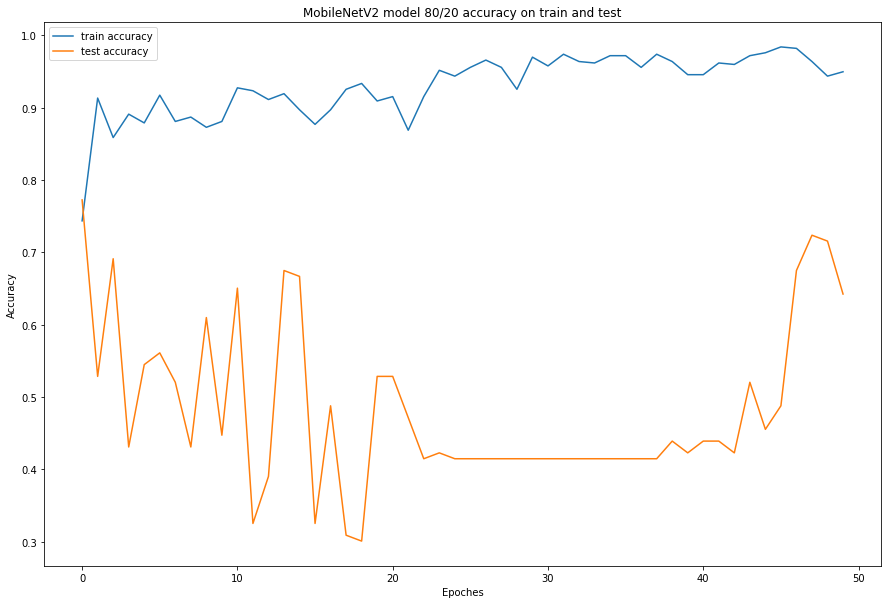

In [58]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(50), history_80_20.history['categorical_accuracy'], label='train accuracy')
plt.plot(np.arange(50), history_80_20.history['val_categorical_accuracy'], label='test accuracy')

plt.legend()
plt.title(f'MobileNetV2 model 80/20 accuracy on train and test')
plt.xlabel('Epoches')
plt.ylabel('Accuracy');

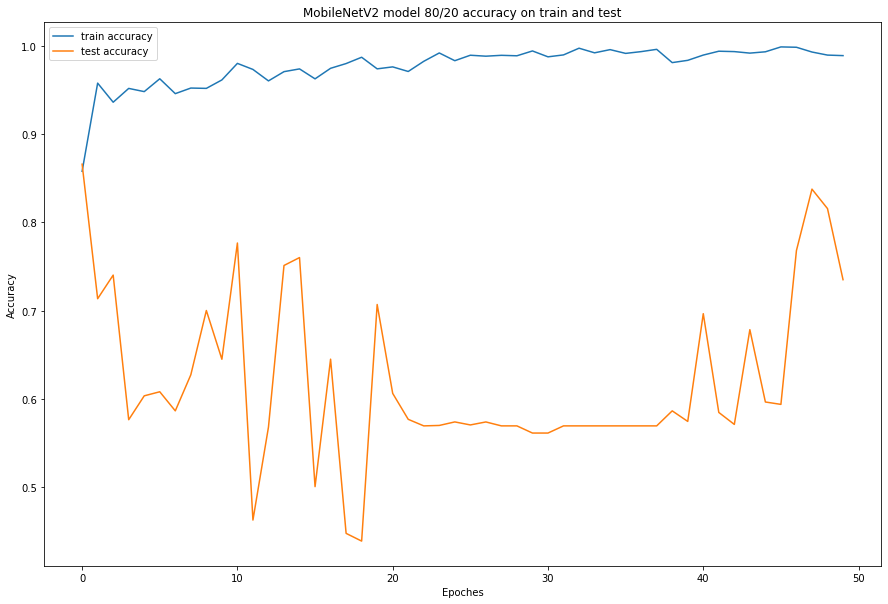

In [56]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(50), history_80_20.history['auc_3'], label='train accuracy')
plt.plot(np.arange(50), history_80_20.history['val_auc_3'], label='test accuracy')

plt.legend()
plt.title(f'MobileNetV2 model 80/20 accuracy on train and test')
plt.xlabel('Epoches')
plt.ylabel('Accuracy');

## Train model on 70/30 dataset

In [59]:
mob_net_model_70_30 = mobileNetV2Model()
with tf.device("GPU"):
    history_70_30 = mob_net_model_70_30.fit(df_train_70_30, validation_data=df_test_70_30, epochs=50)

Epoch 1/50
14/14 [==============================] - 15s 823ms/step - loss: 1.0745 - categorical_accuracy: 0.6642 - auc_4: 0.8084 - binary_accuracy: 0.6667 - val_loss: 1.0175 - val_categorical_accuracy: 0.7391 - val_auc_4: 0.8607 - val_binary_accuracy: 0.6667
Epoch 2/50
14/14 [==============================] - 10s 683ms/step - loss: 0.9679 - categorical_accuracy: 0.9477 - auc_4: 0.9798 - binary_accuracy: 0.6667 - val_loss: 0.9621 - val_categorical_accuracy: 0.7174 - val_auc_4: 0.8276 - val_binary_accuracy: 0.6667
Epoch 3/50
14/14 [==============================] - 10s 721ms/step - loss: 0.8705 - categorical_accuracy: 0.9215 - auc_4: 0.9635 - binary_accuracy: 0.6678 - val_loss: 1.1024 - val_categorical_accuracy: 0.4130 - val_auc_4: 0.5689 - val_binary_accuracy: 0.6087
Epoch 4/50
14/14 [==============================] - 10s 699ms/step - loss: 0.8176 - categorical_accuracy: 0.8327 - auc_4: 0.9212 - binary_accuracy: 0.7874 - val_loss: 0.7439 - val_categorical_accuracy: 0.8533 - val_auc_4: 0

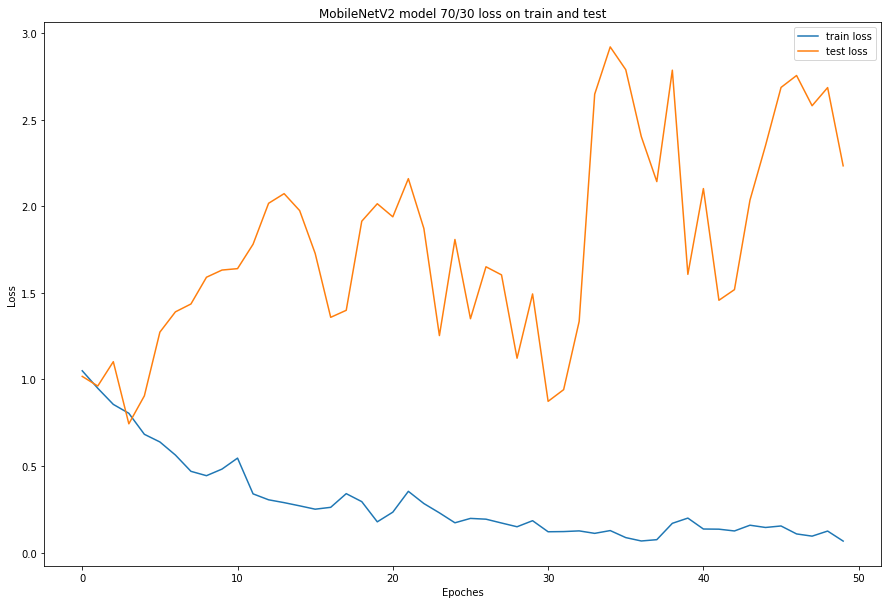

In [60]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(50), history_70_30.history['loss'], label='train loss')
plt.plot(np.arange(50), history_70_30.history['val_loss'], label='test loss')

plt.legend()
plt.title(f'MobileNetV2 model 70/30 loss on train and test')
plt.xlabel('Epoches')
plt.ylabel('Loss');

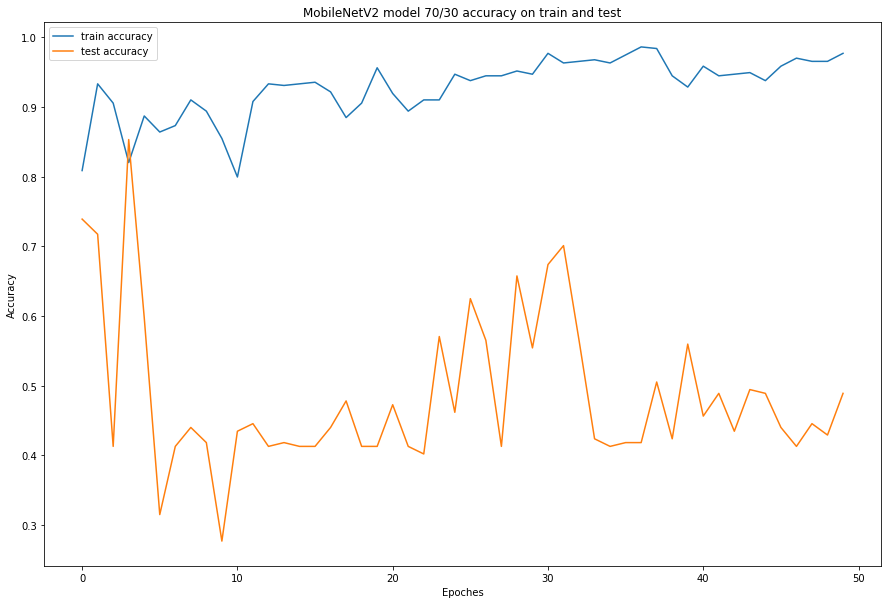

In [61]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(50), history_70_30.history['categorical_accuracy'], label='train accuracy')
plt.plot(np.arange(50), history_70_30.history['val_categorical_accuracy'], label='test accuracy')

plt.legend()
plt.title(f'MobileNetV2 model 70/30 accuracy on train and test')
plt.xlabel('Epoches')
plt.ylabel('Accuracy');

> In the case of pre-trained models, the situation is not the same as with custom losses and the accuracy of the model varies greatly and does not have a clear trend. <br>
> I think this is due to the fact that the model is too deep, 50 epochs are not enough for it to learn.

# Results

In [106]:
def metrics(y_test, y_pred):
    print('f1_score =', f1_score(y_test, y_pred, average='weighted'))
#     print(roc_auc_score(y_test, y_pred, multi_class='ovo'))
    print('recall =', recall_score(y_test, y_pred, average='weighted'))
    print('precision =', precision_score(y_test, y_pred,average='weighted'))
    conf_mat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(15, 15))
    sns.heatmap(conf_mat/len(y_test) * 100, annot=True)

In [98]:
pred_custom_80_20 = custom_model_80_20.predict(df_test_80_20)
pred_mob_net_80_20 = mob_net_model_80_20.predict(df_test_80_20)

pred_mob_net_70_30 = mob_net_model_70_30.predict(df_test_70_30)
pred_custom_70_30 = custom_model_70_30.predict(df_test_70_30)

In [99]:
pred_custom_80_20 = np.argmax(pred_custom_80_20, axis=1)
pred_custom_70_30 = np.argmax(pred_custom_70_30, axis=1)

pred_mob_net_80_20 = np.argmax(pred_mob_net_80_20, axis=1)
pred_mob_net_70_30 = np.argmax(pred_mob_net_70_30, axis=1)

df_test_y_70_30 = [df_test_70_30.classes[i - 1] for i in df_test_70_30.index_array]
df_test_y_80_20 = [df_test_80_20.classes[i - 1] for i in df_test_80_20.index_array]

f1_score = 0.3174206481790845
recall = 0.3170731707317073
precision = 0.31882851952538366


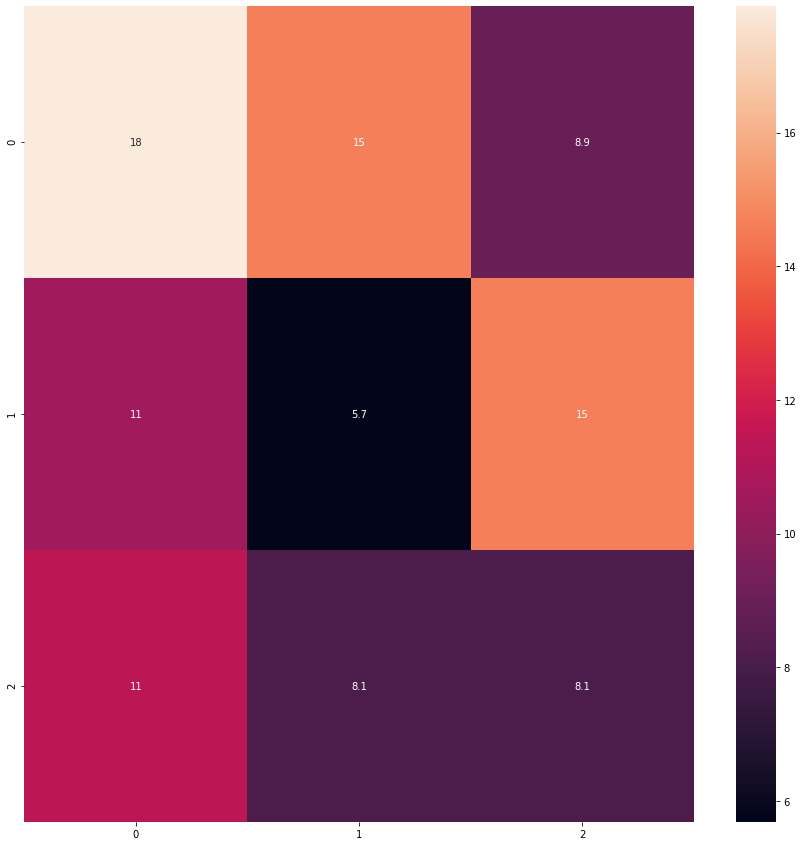

In [107]:
metrics(df_test_y_80_20, pred_custom_80_20)

f1_score = 0.346137371593192
recall = 0.34782608695652173
precision = 0.3447188589249679


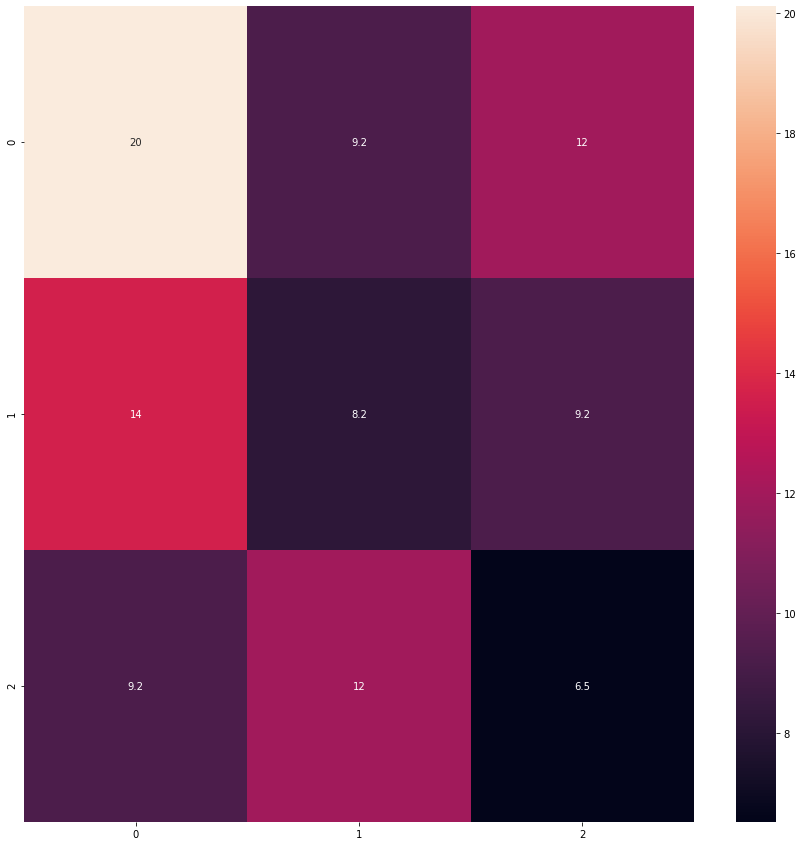

In [108]:
metrics(df_test_y_70_30, pred_custom_70_30)

f1_score = 0.29181836839238995
recall = 0.3252032520325203
precision = 0.32907308578812133


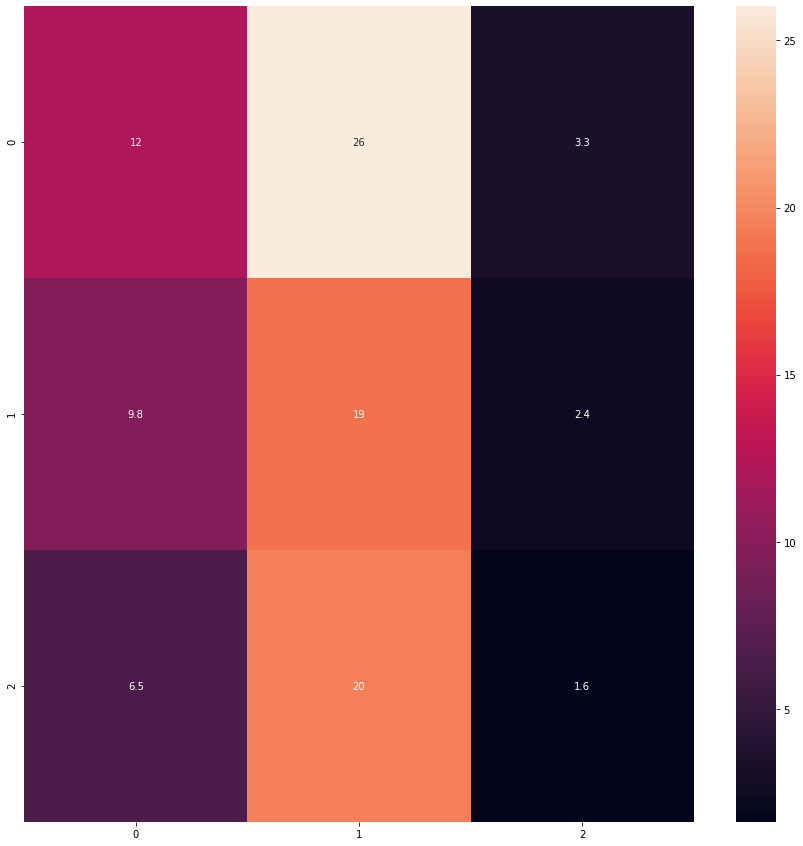

In [109]:
metrics(df_test_80_20.classes, pred_mob_net_80_20)

f1_score = 0.25452289912356074
recall = 0.34782608695652173
precision = 0.2571569734613213


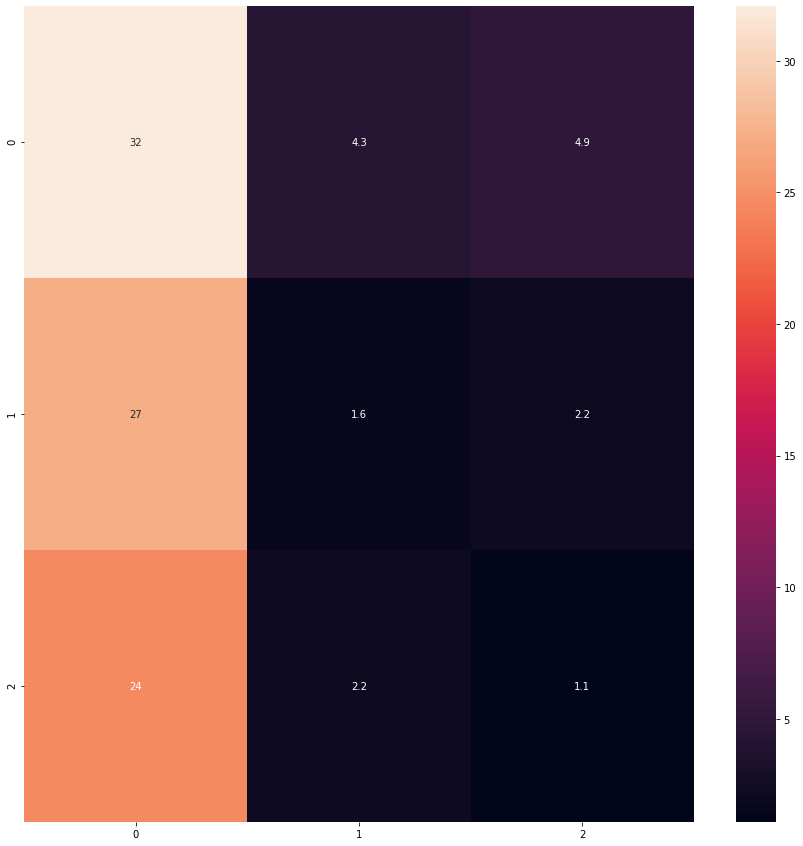

In [110]:
metrics(df_test_70_30.classes, pred_mob_net_70_30)

In this case my models shown not enoght goot result.
<table width='100%'>
<tr>
    <td>model name</td>
    <td>f1_score</td>
    <td>recall</td>
    <td>precision</td>
</tr>
<tr>
    <td>custom_model_80_20</td>
    <td>0.3174206481790845</td>
    <td>0.3170731707317073</td>
    <td>0.31882851952538366</td>
</tr>

<tr>
    <td>custom_model_70_30</td>
    <td>0.346137371593192</td>
    <td>0.34782608695652173</td>
    <td>0.3447188589249679</td>
</tr>
<tr>
    <td>mob_net_model_80_20</td>
    <td>0.29181836839238995</td>
    <td>0.3252032520325203</td>
    <td>0.32907308578812133</td>
</tr>
<tr>
    <td>mob_net_model_70_30</td>
    <td>0.25452289912356074</td>
    <td>0.34782608695652173</td>
    <td>0.2571569734613213</td>

</tr>
</table>

All models showed not the best results across all continents.

Let's take a closer look at the metrics.

Precision can be interpreted as the proportion of objects called positive by the classifier and at the same time really positive, and recall shows what proportion of objects of a positive class from all objects of a positive class the algorithm found.
F1 is harmonic mean precision and recall.

Precision in our results is everywhere less than 35%, which indicates that the accuracy of our model is small, i.e. guessing a certain class is rare.

Recall also does not exceed 35%, this metric shows that our rating is not relevant.

<b>I think the model can be improved by taking the following steps:</b>
- train the model using more epochs
- Use augmentation
- Use a different picture size
- Use a different model (ResNet, Xception, etc)
- Use other hyperparameters

<b>Conclution:</b>

Due to the small number of the model, it was not possible to determine the key features from the pictures without retraining, especially this concerns dombra and kobyz, which are visually quite similar. Perhaps it makes sense to make a combined model that will be downloaded to distinguish the button accordion from stringed instruments, and then distinguish the good from the kobyz